# Introduction
Hello people, welcome to this kernel. In this kernel I am going to generate cat images using Deep Convolutional Generative Adverserive Networks. Before starting, let's take a look at the content of the kernel

# Kernel Content
1. Importing Necessary Libraries
1. Loading Data
1. Generator Model 
1. Discriminator Model
1. Training Model
1. Generating Some Cat Faces
1. Conclusion


# Importing Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import time
from glob import glob
import cv2

main_path = "../input/cats-faces-64x64-for-generative-models/cats"
image_paths = glob(main_path+"/*")

# Loading Data

In [2]:
images = []
for image_path in image_paths:
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(img)
    except:
        print("Something went wrong with this file:\n{}".format(image_path))
    
images = np.array(images)
images = (images-127.5) / 127.5
print(images.shape)

BATCH_SIZE = 256
training_images = tf.data.Dataset.from_tensor_slices(images).shuffle(60000).batch(BATCH_SIZE)

Something went wrong with this file:
../input/cats-faces-64x64-for-generative-models/cats/cats
(15747, 64, 64, 3)


* There are 15747 images in the dataset.

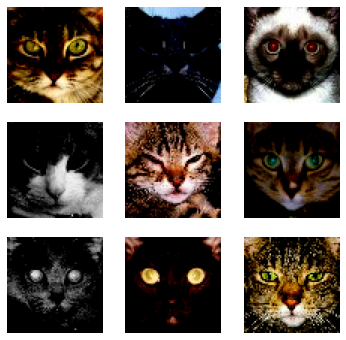

In [3]:
fig = plt.figure(figsize=(6,6))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i*213])
    plt.axis("off")

plt.show()

# Generator Model

In [4]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
def make_generator():
    """
    This function returns a generator model
    """
    model = tf.keras.Sequential()
    
    # Noise with shape 100, to 8,8,256 image
    model.add(layers.Dense(8*8*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8,8,256)))
    
    assert model.output_shape == (None,8,8,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    assert model.output_shape == (None,8,8,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    assert model.output_shape == (None,16,16,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    assert model.output_shape == (None,32,32,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    assert model.output_shape == (None,64,64,3)
    return model
    

In [5]:
generator = make_generator()

In [6]:
# we'll use cross entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

# we'll use adam
generator_optimizer = tf.keras.optimizers.Adam(1e-4)


# Discriminator Model


In [7]:
def make_discriminator():
    """
    This function returns discriminator model
    """
    
    model = tf.keras.models.Sequential()
    # Convolutional Block 1 
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(64,64,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Convolutional Block 2
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Fully Connected
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [8]:
discriminator = make_discriminator()

In [9]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# Training Model

In [23]:
EPOCHS = 200
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    

In [12]:
def train(dataset,epochs):
    
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        print("Epoch {}/{} is finished. Process time: {}".format(epoch+1,epochs,round(time.time()-start,2)))
        print("==========================================================")

In [24]:
train(training_images,EPOCHS)

Epoch 1/200 is finished. Process time: 9.62
Epoch 2/200 is finished. Process time: 7.64
Epoch 3/200 is finished. Process time: 7.92
Epoch 4/200 is finished. Process time: 7.57
Epoch 5/200 is finished. Process time: 7.56
Epoch 6/200 is finished. Process time: 7.59
Epoch 7/200 is finished. Process time: 7.58
Epoch 8/200 is finished. Process time: 7.55
Epoch 9/200 is finished. Process time: 7.59
Epoch 10/200 is finished. Process time: 7.55
Epoch 11/200 is finished. Process time: 7.59
Epoch 12/200 is finished. Process time: 7.57
Epoch 13/200 is finished. Process time: 7.85
Epoch 14/200 is finished. Process time: 7.54
Epoch 15/200 is finished. Process time: 7.48
Epoch 16/200 is finished. Process time: 7.77
Epoch 17/200 is finished. Process time: 7.5
Epoch 18/200 is finished. Process time: 7.63
Epoch 19/200 is finished. Process time: 7.81
Epoch 20/200 is finished. Process time: 7.61
Epoch 21/200 is finished. Process time: 7.62
Epoch 22/200 is finished. Process time: 7.77
Epoch 23/200 is fini

Epoch 80/200 is finished. Process time: 7.53
Epoch 81/200 is finished. Process time: 7.63
Epoch 82/200 is finished. Process time: 7.91
Epoch 83/200 is finished. Process time: 7.63
Epoch 84/200 is finished. Process time: 7.61
Epoch 85/200 is finished. Process time: 7.71
Epoch 86/200 is finished. Process time: 7.58
Epoch 87/200 is finished. Process time: 7.62
Epoch 88/200 is finished. Process time: 7.68
Epoch 89/200 is finished. Process time: 7.61
Epoch 90/200 is finished. Process time: 7.71
Epoch 91/200 is finished. Process time: 7.62
Epoch 92/200 is finished. Process time: 7.58
Epoch 93/200 is finished. Process time: 7.62
Epoch 94/200 is finished. Process time: 7.57
Epoch 95/200 is finished. Process time: 7.55
Epoch 96/200 is finished. Process time: 7.64
Epoch 97/200 is finished. Process time: 7.77
Epoch 98/200 is finished. Process time: 7.77
Epoch 99/200 is finished. Process time: 7.65
Epoch 100/200 is finished. Process time: 7.68
Epoch 101/200 is finished. Process time: 7.63
Epoch 10

Epoch 159/200 is finished. Process time: 7.53
Epoch 160/200 is finished. Process time: 7.87
Epoch 161/200 is finished. Process time: 7.64
Epoch 162/200 is finished. Process time: 7.58
Epoch 163/200 is finished. Process time: 7.62
Epoch 164/200 is finished. Process time: 7.62
Epoch 165/200 is finished. Process time: 7.57
Epoch 166/200 is finished. Process time: 7.54
Epoch 167/200 is finished. Process time: 7.75
Epoch 168/200 is finished. Process time: 7.77
Epoch 169/200 is finished. Process time: 7.57
Epoch 170/200 is finished. Process time: 7.72
Epoch 171/200 is finished. Process time: 7.69
Epoch 172/200 is finished. Process time: 7.56
Epoch 173/200 is finished. Process time: 7.62
Epoch 174/200 is finished. Process time: 7.51
Epoch 175/200 is finished. Process time: 7.61
Epoch 176/200 is finished. Process time: 7.58
Epoch 177/200 is finished. Process time: 7.64
Epoch 178/200 is finished. Process time: 7.58
Epoch 179/200 is finished. Process time: 7.58
Epoch 180/200 is finished. Process

# Generating Some Cat Faces

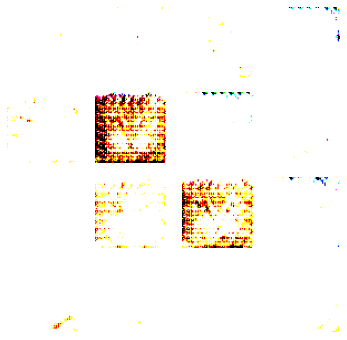

In [14]:
noise = tf.random.normal([16,100])
generated_images = generator(noise,training=False)

fig = plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((generated_images[i,:,:,:]*127.5+127.5))
    plt.axis("off")
    
plt.show()

In [15]:
noise = tf.random.normal([16,100])

In [26]:
generated_images = generator(noise,training=False)


for i in range(16):
    test_image = np.array(generated_images[i,:,:,:]*127.5+127.5).astype(np.uint8)
    test_image = cv2.cvtColor(test_image,cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join("./epoch400_images",f"test{i}.jpg"),test_image)

In [25]:
import os
os.mkdir("./epoch400_images")


In [22]:
os.listdir("./epoch200_images")

['test15.jpg',
 'test7.jpg',
 'test10.jpg',
 'test9.jpg',
 'test11.jpg',
 'test1.jpg',
 'test0.jpg',
 'test8.jpg',
 'test2.jpg',
 'test13.jpg',
 'test14.jpg',
 'test6.jpg',
 'test4.jpg',
 'test12.jpg',
 'test3.jpg',
 'test5.jpg']